# Backtesting Strategies Using Monte Carlo Method

## 1 - Imports & Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from backtesting import Backtest, Strategy
from tqdm.notebook import tqdm

tqdm.pandas()

# ── Configuration ──────────────────────────────────────────────
TICKER = "EURUSD=X"
START_DATE = "2020-01-01"
END_DATE = "2026-01-01"
INTERVAL = "1d"
INITIAL_CASH = 5_000
MARGIN = 1 / 10
COMMISSION = 0.0002
TRADE_SIZE = 0.1
PIP_VALUE = 0.0001
SL_PIPS = 200
SLIPPAGE_SCALE = 0.003

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## 2 - Helper Functions

In [2]:
def load_data(ticker, start_date, end_date, interval):
    """Download OHLCV data from Yahoo Finance."""
    df = yf.download(ticker, start=start_date, end=end_date,
                     interval=interval, auto_adjust=True)
    df.columns = ["Open", "High", "Low", "Close", "Volume"]
    df.reset_index(inplace=True)
    return df


def total_signals(df, current_candle):
    """Detect outside-bar reversal signals.

    Returns
    -------
    2 : bearish outside bar  → enter long at next open
    1 : bullish outside bar  → enter short at next open
    0 : no signal
    """
    pos = df.index.get_loc(current_candle)
    o, h, l, c = (df["Open"].iloc[pos], df["High"].iloc[pos],
                  df["Low"].iloc[pos], df["Close"].iloc[pos])
    prev_h, prev_l, prev_c = (df["High"].iloc[pos - 1],
                              df["Low"].iloc[pos - 1],
                              df["Close"].iloc[pos - 1])

    if o > c and h > prev_h and l < prev_l and c < prev_c:
        return 2  # Bearish outside bar → long signal
    if o < c and h < prev_h and l > prev_l and c > prev_c:
        return 1  # Bullish outside bar → short signal
    return 0


def add_total_signals(df):
    """Compute signals for every row and store in 'Total_Signals'."""
    df["Total_Signals"] = df.progress_apply(
        lambda row: total_signals(df, row.name), axis=1
    )
    return df


def add_pointpos_column(df, signal_column="Total_Signals"):
    """Add marker positions for chart visualisation."""
    def pointpos(row):
        if row[signal_column] == 2:
            return row["Low"] - 1e-4
        if row[signal_column] == 1:
            return row["High"] + 1e-4
        return 0

    df["PointPos"] = df.apply(pointpos, axis=1)
    return df


def calculate_stop_loss(entry_price, pips=SL_PIPS, pip_value=PIP_VALUE,
                        direction="long"):
    """Return stop-loss price a fixed number of pips from *entry_price*."""
    sl_distance = pips * pip_value
    if direction == "long":
        return entry_price - sl_distance
    if direction == "short":
        return entry_price + sl_distance
    raise ValueError("direction must be 'long' or 'short'")


def plot_signals(df, start_index, num_rows):
    """Draw a candlestick chart with buy / sell markers."""
    subset = df.iloc[start_index:start_index + num_rows]

    fig = go.Figure(data=[go.Candlestick(
        x=subset["Date"], open=subset["Open"],
        high=subset["High"], low=subset["Low"],
        close=subset["Close"], name="Candlesticks"
    )])

    for signal_val, label, colour in [(2, "Buy", "green"), (1, "Sell", "red")]:
        pts = subset[subset["Total_Signals"] == signal_val]
        fig.add_trace(go.Scatter(
            x=pts["Date"], y=pts["PointPos"], mode="markers",
            name=f"{label} Signals", marker=dict(color=colour, size=10)
        ))

    fig.update_layout(
        title="Candlestick Chart with Buy/Sell Signals",
        width=1200, height=800,
        plot_bgcolor="black", paper_bgcolor="black",
        font=dict(color="white"),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        legend=dict(x=0.01, y=0.99, bgcolor="black",
                    bordercolor="gray", borderwidth=2,
                    font=dict(family="sans-serif", size=12, color="white")),
    )
    fig.show()

## 3 - Load Data & Compute Signals

In [3]:
df = load_data(TICKER, START_DATE, END_DATE, INTERVAL)
df = add_total_signals(df)
df = add_pointpos_column(df)
df

[*********************100%***********************]  1 of 1 completed


  0%|          | 0/1562 [00:00<?, ?it/s]

,Date,Open,High,Low,Close,Volume,Total_Signals,PointPos
0,2020-01-01,1.122083,1.122838,1.115947,1.122083,0,0,0.0
1,2020-01-02,1.122083,1.122712,1.116682,1.121894,0,0,0.0
2,2020-01-03,1.117144,1.118068,1.112570,1.117081,0,0,0.0
3,2020-01-06,1.116196,1.120825,1.115810,1.116246,0,0,0.0
4,2020-01-07,1.119799,1.119946,1.113487,1.119583,0,0,0.0
...,...,...,...,...,...,...,...,...
1557,2025-12-24,1.179551,1.180916,1.177426,1.179565,0,0,0.0
1558,2025-12-26,1.178536,1.179941,1.176304,1.178384,0,0,0.0
1559,2025-12-29,1.177274,1.178856,1.175406,1.177496,0,0,0.0
1560,2025-12-30,1.177288,1.178134,1.174619,1.177302,0,0,0.0


In [4]:
df["Total_Signals"].value_counts()

Total_Signals
0    1529
2      19
1      14
Name: count, dtype: int64

In [5]:
df[df["Total_Signals"] != 0]

,Date,Open,High,Low,Close,Volume,Total_Signals,PointPos
94,2020-05-12,1.080941,1.088045,1.078539,1.080917,0,2,1.078439
114,2020-06-09,1.130557,1.136338,1.124366,1.130288,0,2,1.124266
125,2020-06-24,1.131235,1.132631,1.125987,1.131363,0,1,1.132731
130,2020-07-01,1.123595,1.127459,1.118919,1.123368,0,2,1.118819
159,2020-08-11,1.173778,1.180498,1.172319,1.173764,0,2,1.172219
180,2020-09-09,1.177024,1.183054,1.175364,1.176914,0,2,1.175264
182,2020-09-11,1.182438,1.187648,1.182592,1.182620,0,1,1.187748
230,2020-11-18,1.186366,1.189100,1.185115,1.186437,0,1,1.189200
233,2020-11-23,1.186648,1.190590,1.180317,1.186535,0,2,1.180217
239,2020-12-01,1.193816,1.205357,1.193599,1.193773,0,2,1.193499


In [6]:
plot_signals(df, start_index=100, num_rows=500)

## 4 - Backtesting: Trade Management A (SL/TP %)

In [7]:
class TradeManagementA(Strategy):
    """Simple percentage-based stop-loss / take-profit strategy."""

    size = TRADE_SIZE
    sl_pct = 0.06
    tp_pct = 0.04

    def init(self):
        super().init()

    def next(self):
        signal = self.data.Total_Signals[-1]
        price = self.data.Close[-1]

        if signal == 2 and not self.position:
            self.buy(size=self.size,
                     sl=price * (1 - self.sl_pct),
                     tp=price * (1 + self.tp_pct))

        elif signal == 1 and not self.position:
            self.sell(size=self.size,
                      sl=price * (1 + self.sl_pct),
                      tp=price * (1 - self.tp_pct))

In [8]:
bt = Backtest(df, TradeManagementA, cash=INITIAL_CASH,
              margin=MARGIN, commission=COMMISSION, finalize_trades=True)

stats, heatmap = bt.optimize(
    sl_pct=[i / 100 for i in range(1, 8)],
    tp_pct=[i / 100 for i in range(1, 8)],
    maximize="Return [%]",
    max_tries=3000,
    random_state=0,
    return_heatmap=True,
)

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/2645773974.py:1: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/backtesting/backtesting.py:1624: RuntimeWarning:

If you want to use multi-process optimization with `multiprocessing.get_start_method() == 'spawn'` (e.g. on Windows),set `backtesting.Pool = multiprocessing.Pool` (or of the desired context) and hide `bt.optimize()` call behind a `if __name__ == '__main__'` guard. Currently using thread-based paralellism, which might be slightly slower for non-numpy / non-GIL-releasing code. See https://github.com/kernc/backtesting.py/issues/1256



Backtest.optimize:   0%|          | 0/49 [00:00<?, ?it/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

In [9]:
stats._strategy

<Strategy TradeManagementA(sl_pct=0.06,tp_pct=0.04)>

In [10]:
bt = Backtest(df, TradeManagementA, cash=INITIAL_CASH,
              margin=MARGIN, commission=COMMISSION, finalize_trades=True)
stats = bt.run()
stats

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/3349313719.py:1: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Start                                     0.0
End                                    1561.0
Duration                               1561.0
Exposure Time [%]                    48.46351
Equity Final [$]                   5976.84603
Equity Peak [$]                    6103.99005
Commissions [$]                      20.27227
Return [%]                           19.53692
Buy & Hold Return [%]                 4.68448
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                             18.3258
Beta                                  0.25854
Max. Drawdown [%]                    -8.58284
Avg. Drawdown [%]                    -0.96753
Max. Drawdown Duration                  964.0
Avg. Drawdown Duration                   43.5
# Trades                                  9.0
Win Rate [%]                      

In [11]:
bt.plot()

GridPlot(id='p1312', ...)

## 5 - Backtesting: Trade Management B (Pip-Based SL)

In [12]:
class TradeManagementB(Strategy):
    """Pip-based stop-loss; close winning trades immediately."""

    size = TRADE_SIZE

    def init(self):
        super().init()

    def next(self):
        signal = self.data.Total_Signals[-1]

        # Close trades that are already in profit
        for trade in self.trades:
            if trade.pl > 0:
                trade.close()

        if signal == 2 and not self.position:
            price = self.data.Close[-1]
            self.buy(size=self.size,
                     sl=calculate_stop_loss(price, direction="long"))

        elif signal == 1 and not self.position:
            price = self.data.Close[-1]
            self.sell(size=self.size,
                      sl=calculate_stop_loss(price, direction="short"))

In [13]:
bt = Backtest(df, TradeManagementB, cash=INITIAL_CASH,
              margin=MARGIN, commission=COMMISSION, finalize_trades=True)
stats = bt.run()
stats

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/3770066641.py:1: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Start                                     0.0
End                                    1561.0
Duration                               1561.0
Exposure Time [%]                     6.46607
Equity Final [$]                    5220.0783
Equity Peak [$]                    5229.72971
Commissions [$]                      59.48617
Return [%]                            4.40157
Buy & Hold Return [%]                 4.68448
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                             4.41256
Beta                                 -0.00235
Max. Drawdown [%]                    -1.14515
Avg. Drawdown [%]                    -0.38988
Max. Drawdown Duration                  950.0
Avg. Drawdown Duration                 78.875
# Trades                                 29.0
Win Rate [%]                      

In [14]:
bt.plot()

GridPlot(id='p1639', ...)

## 6 - Monte-Carlo Slippage Simulation

In [15]:
class StrategyMonteCarlo(Strategy):
    """Same as TradeManagementB but injects random slippage via
    Gaussian noise on entry price and stop-loss."""

    size = TRADE_SIZE

    def init(self):
        super().init()

    @staticmethod
    def _apply_slippage(price, sl):
        """Perturb *price* and *sl* with Gaussian noise."""
        price = np.random.normal(loc=price, scale=SLIPPAGE_SCALE)
        sl = np.random.normal(loc=sl, scale=SLIPPAGE_SCALE)
        return price, sl

    def next(self):
        signal = self.data.Total_Signals[-1]

        for trade in self.trades:
            if trade.pl > 0:
                trade.close()

        if signal == 2 and not self.position:
            price = self.data.Close[-1]
            sl = calculate_stop_loss(price, direction="long")
            price, sl = self._apply_slippage(price, sl)
            self.buy(size=self.size, sl=sl)

        elif signal == 1 and not self.position:
            price = self.data.Close[-1]
            sl = calculate_stop_loss(price, direction="short")
            price, sl = self._apply_slippage(price, sl)
            self.sell(size=self.size, sl=sl)

In [16]:
bt = Backtest(df.copy(), StrategyMonteCarlo, cash=INITIAL_CASH,
              margin=MARGIN, commission=COMMISSION)
stats = bt.run()
stats

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/1925916704.py:1: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

Start                                     0.0
End                                    1561.0
Duration                               1561.0
Exposure Time [%]                     6.46607
Equity Final [$]                    5220.0783
Equity Peak [$]                    5229.72971
Commissions [$]                      59.48617
Return [%]                            4.40157
Buy & Hold Return [%]                 4.68448
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Alpha [%]                             4.41256
Beta                                 -0.00235
Max. Drawdown [%]                    -1.14515
Avg. Drawdown [%]                    -0.38988
Max. Drawdown Duration                  950.0
Avg. Drawdown Duration                 78.875
# Trades                                 29.0
Win Rate [%]                      

In [17]:
bt.plot()

GridPlot(id='p1966', ...)

## 7 - Repeating the Backtest for N Iterations

In [18]:
NUM_ITERATIONS = 1_000
results = []

for _ in tqdm(range(NUM_ITERATIONS), desc="Monte Carlo Simulations"):
    bt = Backtest(df.copy(), StrategyMonteCarlo, cash=INITIAL_CASH,
                  margin=MARGIN, commission=COMMISSION)
    results.append(bt.run())

Monte Carlo Simulations:   0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

/var/folders/w5/18qdbhzs6rx3_c589r7xzzsw0000gn/T/ipykernel_45801/126067034.py:5: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Backtest.run:   0%|          | 0/1561 [00:00<?, ?bar/s]

In [19]:
results

[Start                                     0.0
 End                                    1561.0
 Duration                               1561.0
 Exposure Time [%]                     6.46607
 Equity Final [$]                    5220.0783
 Equity Peak [$]                    5229.72971
 Commissions [$]                      59.48617
 Return [%]                            4.40157
 Buy & Hold Return [%]                 4.68448
 Return (Ann.) [%]                         0.0
 Volatility (Ann.) [%]                     NaN
 Sharpe Ratio                              NaN
 Sortino Ratio                             NaN
 Calmar Ratio                              0.0
 Alpha [%]                             4.41256
 Beta                                 -0.00235
 Max. Drawdown [%]                    -1.14515
 Avg. Drawdown [%]                    -0.38988
 Max. Drawdown Duration                  950.0
 Avg. Drawdown Duration                 78.875
 # Trades                                 29.0
 Win Rate [%]

In [20]:
equity_curves = [s["_equity_curve"]["Equity"] for s in results]
max_len = max(len(eq) for eq in equity_curves)

# Pad each curve with its final value so all have equal length
padded = [
    eq.tolist() + [eq.iloc[-1]] * (max_len - len(eq))
    for eq in equity_curves
]
equity_df = pd.DataFrame(padded).T
equity_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
1,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
2,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
3,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
4,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,...,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298
1558,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,...,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298
1559,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,...,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298
1560,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,...,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298,5220.078298


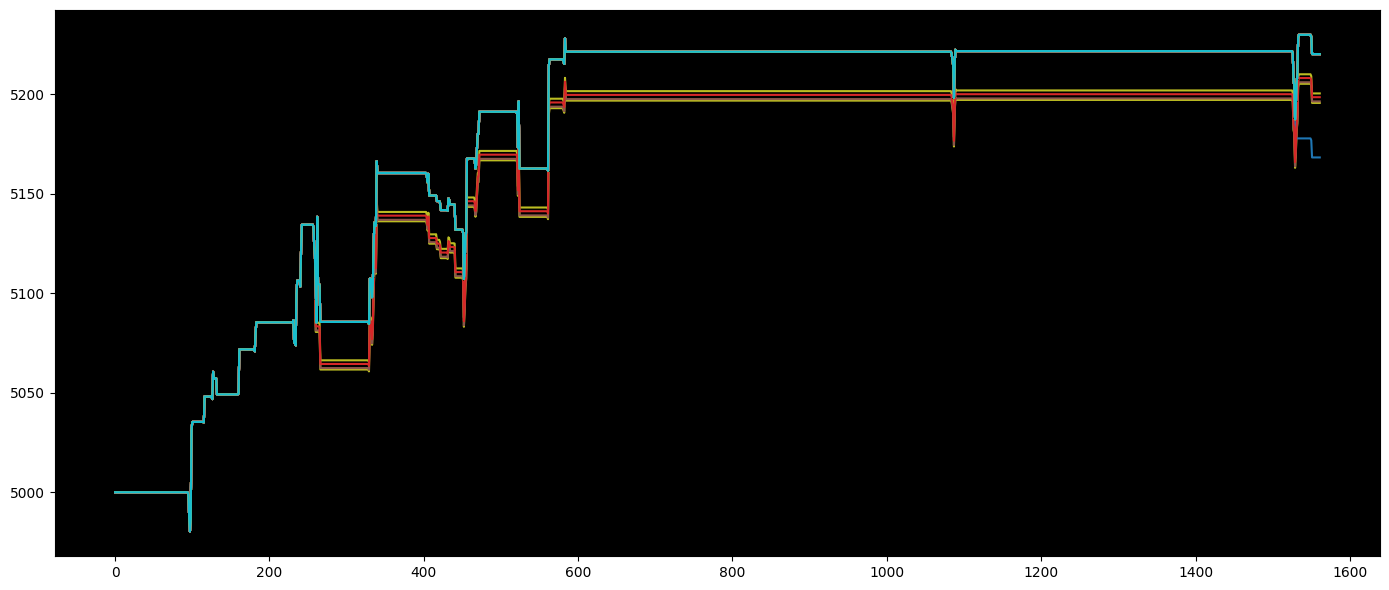

In [21]:
ax = equity_df.plot(kind="line", figsize=(14, 6), legend=False)
ax.set_facecolor("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")
plt.tight_layout()
plt.show()

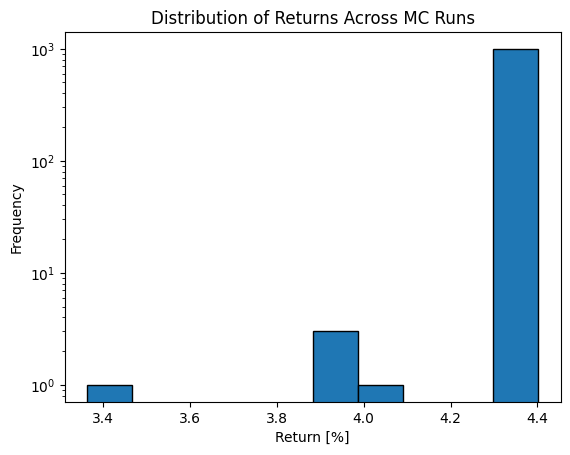

In [33]:
returns_pct = [r["Return [%]"] for r in results]
plt.hist(returns_pct, bins=10, edgecolor="black")
plt.yscale('log')
plt.title("Distribution of Returns Across MC Runs")
plt.xlabel("Return [%]")
plt.ylabel("Frequency")
plt.show()

## 8 - Trade Sampling via Monte Carlo

In [23]:
results[0]["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,Commission,ReturnPct,EntryTime,ExitTime,Duration,Tag
0,4608,95,100,1.084681,1.092777,1.065579,None,35.298431,2.006745,0.007062,95,100,5,None
1,4442,115,116,1.133222,1.136544,1.114830,None,12.744124,2.016460,0.002532,115,116,1,None
2,-4485,126,128,1.125087,1.122586,1.149008,None,9.199801,2.016163,0.001823,126,128,2,None
3,4493,131,132,1.125138,1.123785,1.105443,None,-8.099490,2.020882,-0.001602,131,132,1,None
4,4301,160,161,1.173654,1.179380,1.159184,None,22.604897,2.024080,0.004478,160,161,1,None
5,4294,181,183,1.180638,1.184273,1.156778,None,13.578938,2.030985,0.002678,181,183,2,None
6,-4291,231,232,1.184764,1.186648,1.203863,None,-10.118808,2.035146,-0.001990,231,232,1,None
7,4284,234,236,1.184273,1.192000,1.168231,None,31.068125,2.035991,0.006124,234,236,2,None
8,4228,240,242,1.207438,1.214565,1.174841,None,28.085611,2.048046,0.005502,240,242,2,None
9,-4212,257,263,1.218472,1.225070,1.238663,None,-29.848193,2.058440,-0.005816,257,263,6,None


In [24]:
def trades_sampling(results, select_pct=50, equity=INITIAL_CASH):
    """Randomly sample *select_pct* % of trades from each MC run and
    return the resulting PnL as a percentage of starting equity."""
    return [
        r["_trades"].sample(frac=select_pct / 100)["PnL"].sum()
        / equity * 100
        for r in results
    ]


sampled_returns = trades_sampling(results)
len(sampled_returns)

1000

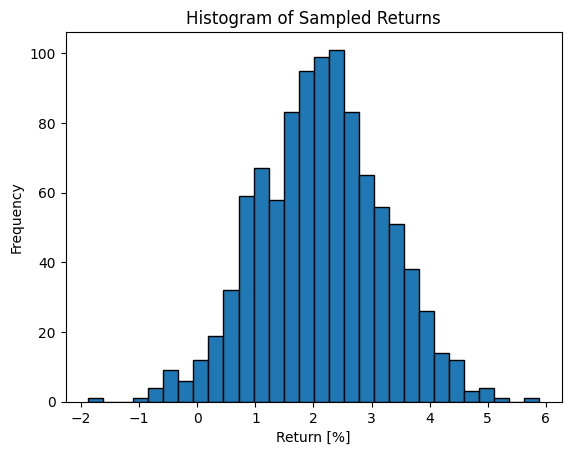

In [25]:
plt.hist(sampled_returns, bins=30, edgecolor="black")
plt.title("Histogram of Sampled Returns")
plt.xlabel("Return [%]")
plt.ylabel("Frequency")
plt.show()

## 9 - Iterated Trade Sampling & Risk Assessment

In [26]:
SAMPLING_ITERATIONS = 100
SAMPLE_FRACTION = 80  # percent of trades to keep per sample

all_sampled_returns = []
for _ in range(SAMPLING_ITERATIONS):
    all_sampled_returns.extend(
        trades_sampling(results, select_pct=SAMPLE_FRACTION)
    )

print(f"Total sampled return observations: {len(all_sampled_returns):,}")

Total sampled return observations: 100,000


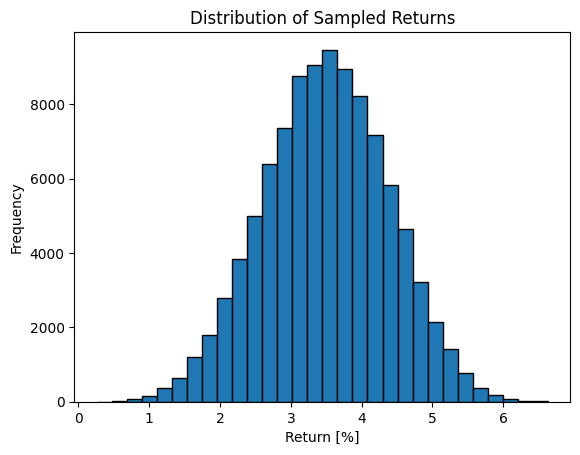

Estimated risk (P[return < 0]): 0.00%


In [27]:
counts, bins, _ = plt.hist(all_sampled_returns, bins=30, edgecolor="black")
plt.title("Distribution of Sampled Returns")
plt.xlabel("Return [%]")
plt.ylabel("Frequency")
plt.show()

# Estimate probability of negative returns
negative_count = sum(c for c, b in zip(counts, bins[:-1]) if b < 0)
risk = negative_count / counts.sum()
print(f"Estimated risk (P[return < 0]): {risk:.2%}")